In [1]:
from vc_clothes_dataset import VCClothesDataset, build_transforms
from face_dataset import FaceDataset
from face_detector import FaceDetector
from face_feature_extractor import FaceFeatureExtractor
from face_feature_extractor_wrapper import FaceReIDTrainWrapper
from trainer import Trainer

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\janek\AppData\Roaming\Python\Python312\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\janek\AppData\Roaming\Python\Python312\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\janek\AppData\Roaming\Python\Python312\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

In [2]:
DATA_ROOT = "./data/vc_clothes"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
LR = 0.00035
EPOCHS = 3

In [28]:
# Tworzenie transformacji
train_transforms = build_transforms(is_train=True)
val_transforms = build_transforms(is_train=False)

# Instancja datasetu treningowego
# VC-Clothes ma 9,449 obrazów treningowych [cite: 194]
train_set = VCClothesDataset(DATA_ROOT, mode="train", transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)


gallery_set = VCClothesDataset(DATA_ROOT, mode="gallery", transform=train_transforms)
gallery_loader = DataLoader(gallery_set, batch_size=32, shuffle=True, num_workers=4)

# Instancja datasetu testowego (Query)
# VC-Clothes ma 1,020 obrazów query [cite: 194]
query_set = VCClothesDataset(DATA_ROOT, mode="query", transform=val_transforms)
test_loader = DataLoader(query_set, batch_size=32, shuffle=False, num_workers=4)

print("\nPrzykładowy element batcha:")
imgs, pids, cams, clothes = next(iter(train_loader))
print(f"Shape obrazów: {imgs.shape}")  # Oczekiwane [32, 3, 256, 128]
print(f"PIDs: {pids}")
print(f"Clothes IDs: {clothes}")

Załadowano zbiór VC-Clothes (train):
  Liczba obrazów: 9449
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (gallery):
  Liczba obrazów: 8591
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3
Załadowano zbiór VC-Clothes (query):
  Liczba obrazów: 1020
  Liczba unikalnych ID: 256
  Liczba kamer: 4
  Liczba unikalnych ubrań: 3

Przykładowy element batcha:
Shape obrazów: torch.Size([32, 3, 256, 128])
PIDs: tensor([ 89,  14,  59, 211, 223,  66, 172,  24, 217, 238,  37,   3, 233,  91,
        209,  84, 240, 160,  24, 230, 150,  37, 235,   0, 125,  36, 223,  52,
        167, 172,  56,  55])
Clothes IDs: tensor([1, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 1, 1, 3, 1,
        1, 1, 1, 3, 3, 3, 3, 3])


In [24]:
imgs_batch, pids_batch, cams_batch, clothes_batch = next(iter(train_loader))

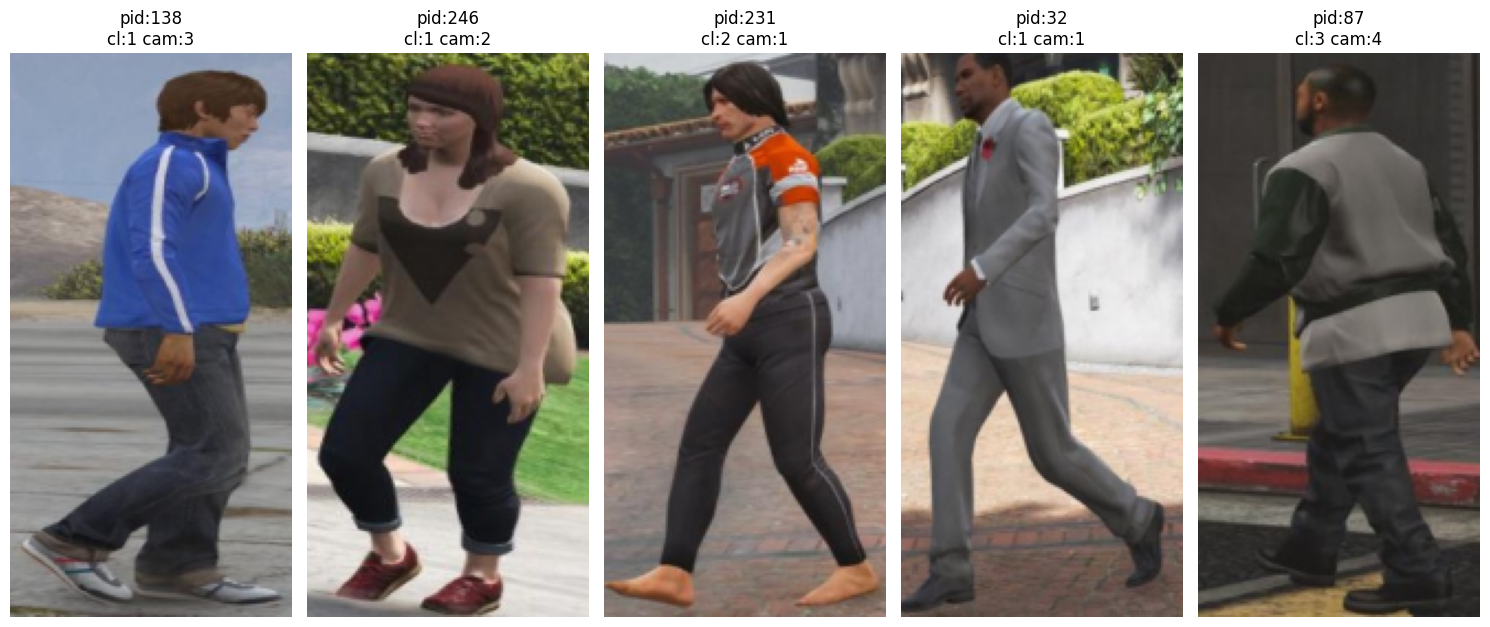

In [25]:
N = min(5, imgs_batch.size(0))


fig, axes = plt.subplots(1, N, figsize=(N * 3, 8))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    img = np.transpose(imgs_batch[i], (1, 2, 0))
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

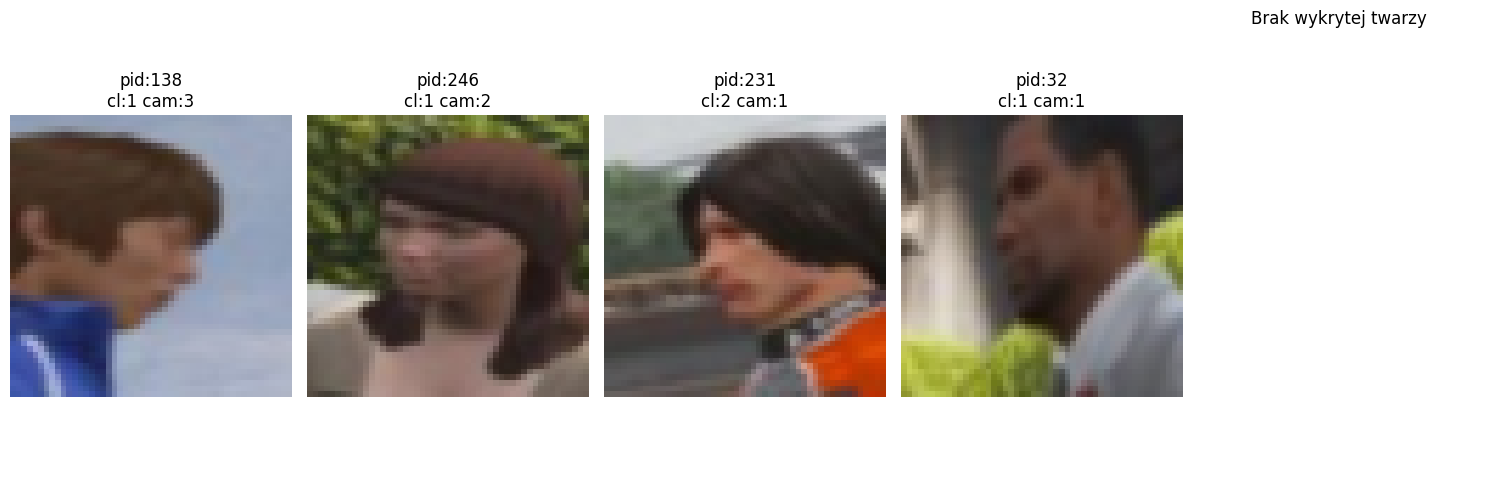

In [26]:
N = min(5, imgs_batch.size(0))

detector = FaceDetector(device=DEVICE)

fig, axes = plt.subplots(1, N, figsize=(N * 3, 5))
if N == 1:
    axes = [axes]

for i in range(N):
    ax = axes[i]
    img = transforms.ToPILImage()(imgs_batch[i])
    face_tensor = detector.get_face_tensor(img)
    if face_tensor is None:
        ax.set_title("Brak wykrytej twarzy")
        ax.axis("off")
        continue
    face = transforms.ToPILImage()(face_tensor[0])
    ax.imshow(face)
    ax.axis("off")
    ax.set_title(
        f"pid:{int(pids_batch[i])}\ncl:{int(clothes_batch[i])} cam:{int(cams_batch[i])}"
    )

plt.tight_layout()
plt.show()

In [23]:
detector = FaceDetector(device=DEVICE, confidence_threshold=0.5)

In [21]:
import os
from tqdm import tqdm
from PIL import Image
import torch


def save_face_dataset(dataset: Dataset, save_dir_base: str):
    processed = 0
    detected = 0

    for img, pid, camid, clothid in tqdm(dataset):
        processed += 1

        img_tmp = transforms.ToPILImage()(img)

        # Detekcja twarzy (zwraca Tensor na GPU lub None)
        with torch.no_grad():  # Detektor nie jest trenowany!
            face_tensor = detector.get_face_tensor(img_tmp)

        if face_tensor is not None:
            detected += 1

            # Konwersja Tensora z powrotem na obraz PIL do zapisu
            # Tensor ma kształt (1, 3, 50, 50) i jest znormalizowany -> trzeba odkręcić
            face_tensor = face_tensor.squeeze(0).cpu()

            # Denormalizacja (odwrócenie ImageNet norm) dla celów wizualnych/zapisu
            # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            # face_img_tensor = face_tensor * std + mean
            # face_img_tensor = torch.clamp(face_img_tensor, 0, 1)

            to_pil = transforms.ToPILImage()
            face_pil = to_pil(face_tensor)

            # Struktura katalogów: target_root/train/PID/
            # Dzięki temu łatwo użyć ImageFolder w przyszłości
            pid_dir = os.path.join(save_dir_base, f"{pid:04d}")
            os.makedirs(pid_dir, exist_ok=True)

            # Nazwa pliku zachowująca metadane
            filename = f"c{camid}_t{clothid}_{processed}.jpg"
            face_pil.save(os.path.join(pid_dir, filename))

    print(f"Przetworzono obrazów: {processed}, zdetektowano twarzy: {detected}")

In [27]:
save_face_dataset(train_set, "./data/vc_clothes_faces/train_faces")

100%|██████████| 9449/9449 [06:37<00:00, 23.78it/s]

Przetworzono obrazów: 9449, zdetektowano twarzy: 6585


In [29]:
save_face_dataset(gallery_set, "./data/vc_clothes_faces/gallery_faces")

100%|██████████| 8591/8591 [06:45<00:00, 21.16it/s]

Przetworzono obrazów: 8591, zdetektowano twarzy: 5919


In [22]:
save_face_dataset(query_set, "./data/vc_clothes_faces/query_faces")

100%|██████████| 1020/1020 [00:41<00:00, 24.79it/s]

Przetworzono obrazów: 1020, zdetektowano twarzy: 743


In [ ]:
query_dataset = FaceDataset("./data/vc_clothes_faces", mode="query")

Znaleziono 743 obrazów w ./data/vc_clothes_faces/query_faces
Znaleziono 253 unikalnych klas (PIDów).
Załadowano FaceDataset (query): 743 obrazów, 253 klas.
